Pre-Trained CNN

# New Section

In [ ]:
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet152', pretrained=True)
model = model.eval()
input_image = Image.open("/content/drive/My Drive/peppers.jpg")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
probs = torch.nn.functional.softmax(output[0], dim=0)
cpu_probs = probs.cpu()
top = np.argpartition(cpu_probs, -3)[-3:]
print(top)
print(cpu_probs[top])

ImportError: ignored

Top is 945: Bell Pepper
943: cucumber / cuke 
941: acorn squash


tensor([941, 943, 945])
tensor([1.7765e-05, 1.1114e-03, 9.9882e-01])

https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [ ]:
normalized_arrs = []
def plot_image(normalized_arr, width, height, px_width, px_height):
  from matplotlib import pyplot as plt
  normalized_arrs.append(normalized_arr)
  total_channels = width * height
  plt.figure(figsize=(px_width, px_height))
  imgs_per_row = width
  for i in range(0,total_channels,imgs_per_row):
    for j in range(0,imgs_per_row):
      plt.subplot(total_channels / imgs_per_row, imgs_per_row, i + j+1)
      plt.axis("off")
      plt.imshow(normalized_arr[0][i + j])
  plt.tight_layout(pad=0.0)
  plt.show()
def create_image_map(conv_ref, width, height, px_width, px_height):
  outputs= []
  def hook(module, input, output):
    outputs.append(output)
  hk = conv_ref.register_forward_hook(hook)
  out = model(input_batch)
  hk.remove()
  imgarr = np.array(outputs[0].cpu().detach())
  minVal = np.amin(imgarr)
  maxVal = np.amax(imgarr)
  normalized_arr = (imgarr - minVal)/(maxVal - minVal)
  # Batch x Channels X Height X Width
  plot_image(normalized_arr, width, height, px_width, px_height)


In [ ]:
create_image_map(model.layer1[0].conv1,8,8,8,8)
create_image_map(model.layer1[0].conv2,8,8,8,8)
create_image_map(model.layer1[0].conv3,16,16,8,8)
create_image_map(model.layer1[1].conv1,8,8,8,8)
create_image_map(model.layer1[1].conv2,8,8,8,8)
create_image_map(model.layer2[5].conv1,16,8,8,4)
create_image_map(model.layer2[5].conv2,16,8,8,4)
create_image_map(model.layer2[5].conv3,32,16,8,4)
create_image_map(model.layer3[0].conv2,16,16,8,8)
create_image_map(model.layer3[0].conv3,32,32,8,8)
create_image_map(model.layer3[19].conv2,16,16, 8, 8)   
create_image_map(model.layer3[24].conv3,32,32, 8, 8)
create_image_map(model.layer4[1].conv3,64,32, 8, 4)
create_image_map(model.layer4[2].conv2,32,16, 8, 4)
create_image_map(model.layer4[2].conv3,64,32, 8, 4)

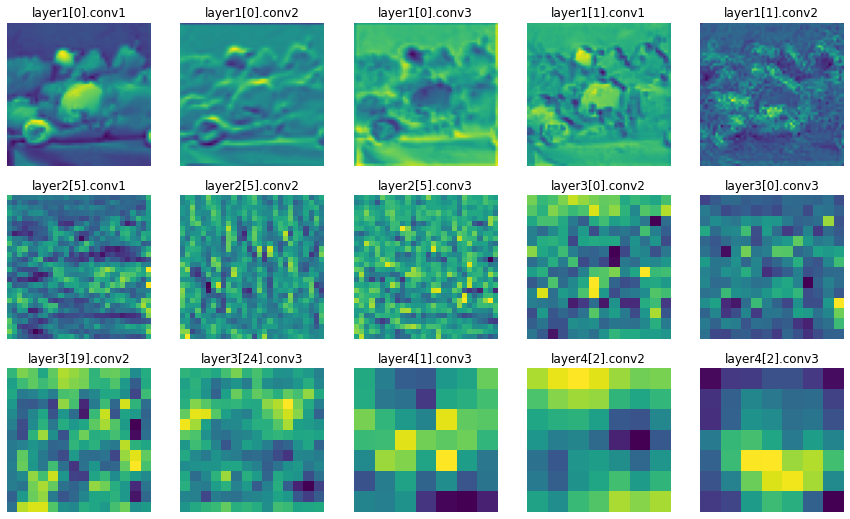

In [ ]:
# This holds the channel we want to display per image
channel_num_per_image = [2,2,4,1,15,4,4,4,3,4,4,4,4,4,4]
img_labels =["layer1[0].conv1",
             "layer1[0].conv2",
             "layer1[0].conv3",
             "layer1[1].conv1",
             "layer1[1].conv2",
             "layer2[5].conv1",
             "layer2[5].conv2",
             "layer2[5].conv3",
             "layer3[0].conv2",
             "layer3[0].conv3",
             "layer3[19].conv2",
             "layer3[24].conv3",
             "layer4[1].conv3",
             "layer4[2].conv2",
             "layer4[2].conv3"
            ]

plt.figure(figsize=(15, 9))
imgs_per_row = 5
total_channels = 15
for i in range(0,total_channels,imgs_per_row):
  for j in range(0,imgs_per_row):
    plt.subplot(total_channels / imgs_per_row, imgs_per_row, i + j+1)
    display_one_channel(i+j,2,img_labels[i+j])


In [ ]:
def display_one_channel(conv_idx, channel_idx, title):
  plt.imshow(normalized_arrs[conv_idx][0][channel_idx])
  plt.axis("off")
  plt.title(title)

## Question 2: Transfer Learning

In [ ]:
# Unzip image & annotation files and copy everything to permanent storage
import tarfile
import errno
import shutil
tar = tarfile.open("/content/drive/My Drive/images.tar.gz")
tar.extractall()
tar.close()
tar2 = tarfile.open("/content/drive/My Drive/annotations.tar.gz")
tar2.extractall()
tar2.close()
def copy(src, dest):
    try:
        shutil.copytree(src, dest)
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)
copy('/content/images','/content/drive/My Drive/images2')
copy('/content/annotations','/content/drive/My Drive/annotations')


In [ ]:
from PIL import Image
from torchvision import transforms
# Get the pet images ready to the pre-trained ResNet-152 network
def preprocess_img(image_path): 
  input_image = Image.open(image_path)
  if input_image.mode == "RGBA":
    input_image = input_image.convert('RGB')
  preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input_tensor = preprocess(input_image)
  # create a mini-batch as expected by the model 
  input_batch = input_tensor.unsqueeze(0)  
  return input_batch

In [ ]:
import numpy as np
pet_vals = np.loadtxt("/content/drive/My Drive/annotations/list.txt",dtype="str")
# Get the image names
X = pet_vals[:,0]


In [ ]:
# Replace the last layer in the CNN with an identity layer
from torch import nn
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
model.fc = Identity()

In [ ]:
# Go through all the pet pictures, featurize them via the CNN
# Save the featurized vectors in an npy file
# Takes about 1.5 hours to run
model = model.to("cuda")
cnt = 0
ft_lst = []
err_lst = []
for pic_name in X:
  if cnt % 100 == 0:
    print(cnt)
    torch.cuda.empty_cache()
  try: 
    input_batch = preprocess_img("/content/drive/My Drive/images2/" + 
                                 pic_name + ".jpg")
  except Exception as e:
    err_lst.append(cnt)
    print("Error ")
    print(e)
    print(cnt)
    cnt = cnt + 1
    continue
  input_batch = input_batch.to('cuda')
  with torch.no_grad():
    ft= model(input_batch)
    ft_lst.append(ft)
  cnt = cnt + 1
ft_lst = np.array(ft_lst)
np.save("preclassified2.npy",ft_lst)

In [ ]:
# Load the featurized vectors, training and testing indices
import numpy as np
ft_lst = np.load("/content/drive/My Drive/preclassified2.npy",allow_pickle='true')
train_vals = np.loadtxt("/content/drive/My Drive/annotations/trainval.txt",dtype="str")
test_vals = np.loadtxt("/content/drive/My Drive/annotations/test.txt",dtype="str")
# Need to find the indices for training set
train_names = train_vals[:,0]
test_names = test_vals[:,0]
# Contains the indices reserved for the test set - it's just everything 3680 +
idx_test = np.where(X == test_names[:, None])[1]

In [ ]:
# Normalizes the featurized vector in prep for classifier
# Dividing by L2 norm
def normalize_feature(feature_tensor):
  from numpy.linalg import norm
  detached_arr = feature_tensor.cpu().detach()
  norm_val = norm(detached_arr)
  normalized = detached_arr/norm_val
  return normalized
normalized_lst = []
for ft_tensor in ft_lst:
  normalized_lst.append(normalize_feature(ft_tensor))

In [ ]:
# Divide into training and test sets
x_train = normalized_lst[0:3680]
x_train_reshaped = []
for x_val in x_train:
   x_train_reshaped.append(x_val.reshape(-1,))
x_train = x_train_reshaped

x_test = normalized_lst[3681:]
x_test_reshaped = []
for x_val in x_test:
  x_test_reshaped.append(x_val.reshape(-1,))
x_test = x_test_reshaped

# Convert 0-36 to 1-37 to work better with the cross-entropy loss
y_train = train_vals[:,1]
y_train = [int(i)-1 for i in y_train]
y_test = test_vals[:,1]
y_test = [int(i)-1 for i in y_test]


In [ ]:
# Use this in the custom dataloader
from torch.utils.data import Dataset, DataLoader
class DLDataset(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, feats, labels):
        'Initialization'
        self.feats = feats
        self.labels = labels

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.feats)

  def __getitem__(self, index):
        # Select sample and get label
        X = self.feats[index]
        y = self.labels[index]
        return X, y

In [ ]:
# Train and Validate the Softmax Classifier
import os
import torch
from torch.utils import data
from torch import nn, optim

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

model = nn.Sequential(nn.Linear(2048,37))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)
model.to(device)

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 50

# Generators
training_set = DLDataset(x_train, y_train)
training_generator = data.DataLoader(training_set, **params)
validation_set = DLDataset(x_test, y_test)
validation_generator = data.DataLoader(validation_set, **params)

mean_class_accuracies = []
confusion_matrix = torch.zeros(37, 37)

# Loop over epochs
for epoch in range(max_epochs):
    running_loss_train = 0.0
    running_loss_test = 0.0
    confusion_matrix = torch.zeros(37, 37)

    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_labels = list(local_labels)
        local_labels = torch.LongTensor(local_labels)
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        # Model computations
        optimizer.zero_grad()        
        output = model(local_batch)
        loss = criterion(output, local_labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
    print('Training loss: %.10f' %
              (running_loss_train))
    # Validation
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in validation_generator:
            # Transfer to GPU
            local_labels = list(local_labels)
            local_labels = torch.LongTensor(local_labels)
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            output = model(local_batch)
            preds = torch.argmax(output, dim=1)
            loss = criterion(output, local_labels)
            running_loss_test += loss.item()
            for t, p in zip(local_labels.view(-1), preds.view(-1)):
              confusion_matrix[t.long(), p.long()] += 1

    print('Testing loss: %.10f' % (running_loss_test))
    # Calculate Mean Per Class Accuracies
    class_accs = []
    confusion_matrix = np.array(confusion_matrix)
    for actual_class_ind in range(0,len(confusion_matrix)):
      class_acc = confusion_matrix[actual_class_ind][actual_class_ind] / confusion_matrix[actual_class_ind].sum()
      class_accs.append(class_acc)
    class_accs = np.array(class_accs)
    acc_percent = class_accs.sum()/len(class_accs)
    print(acc_percent)
    mean_class_accuracies.append(acc_percent)

NameError: ignored

Text(0.5, 1.0, 'Mean Per-Class Accuracy on Test Set')

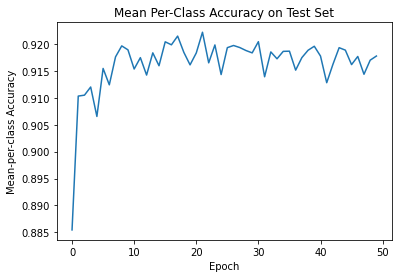

In [ ]:
# Plot mean-per-class accuracy
from matplotlib import pyplot as plt
x_val = list(range(50))
plt.plot(x_val,mean_class_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Mean-per-class Accuracy")
plt.title("Mean Per-Class Accuracy on Test Set")

**CIFAR**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, (11,11))
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.maxpool = nn.MaxPool2d((2,2), 2)
        self.conv2 = nn.Conv2d(64, 128, (3,3))
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(128, 128, (3,3))
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        self.avgpool = nn.AvgPool2d((2,2), 2)
        self.fc1 =  nn.Linear(128 * 3 * 3, 10)
        torch.nn.init.kaiming_normal_(self.fc1.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.avgpool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=6)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=6)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
from torch.utils import data
from torch import nn, optim
import os
import numpy as np
import torch


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

model = CifarNet()
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0004)
model.to(device)

# Parameters
max_epochs = 50
training_losses = []
mean_class_accuracies = []
confusion_matrix = torch.zeros(10, 10)

# Loop over epochs
for epoch in range(max_epochs):
    running_loss_train = 0.0
    running_loss_test = 0.0
    num_items_train = 0
    num_items_test = 0
    confusion_matrix = torch.zeros(10, 10)
    # Training
    for local_batch, local_labels in trainloader:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        # Model computations
        optimizer.zero_grad()        
        output = model(local_batch)
        loss = criterion(output, local_labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
        num_items_train += local_batch.shape[0]
    print('Training loss: %.10f' %
              (running_loss_train / num_items_train))
    training_losses.append(running_loss_train / num_items_train)

    # Validation
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in testloader:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            output = model(local_batch)
            preds = torch.argmax(output, dim=1)

            loss = criterion(output, local_labels)
            running_loss_test += loss.item()
            num_items_test += local_batch.shape[0]

            for t, p in zip(local_labels.view(-1), preds.view(-1)):
              confusion_matrix[t.long(), p.long()] += 1

    print('Testing loss: %.10f' % (running_loss_test / num_items_test))
    # Calculate Mean Per Class Accuracies
    class_accs = []
    confusion_matrix = np.array(confusion_matrix)
    for actual_class_ind in range(0,len(confusion_matrix)):
      class_acc = confusion_matrix[actual_class_ind][actual_class_ind] / confusion_matrix[actual_class_ind].sum()
      class_accs.append(class_acc)
    class_accs = np.array(class_accs)
    acc_percent = class_accs.sum()/len(class_accs)
    print(acc_percent)
    mean_class_accuracies.append(acc_percent)

cuda:0


NameError: ignored

Text(0.5, 1.0, 'Training Loss as a Function of Epoch')

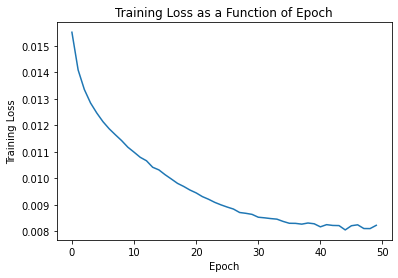

In [ ]:
from matplotlib import pyplot as plt
x_val = list(range(0, 50))
plt.plot(x_val,training_losses[0:50])
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss as a Function of Epoch")

Text(0.5, 1.0, 'Mean Per-Class Accuracy on Test Set')

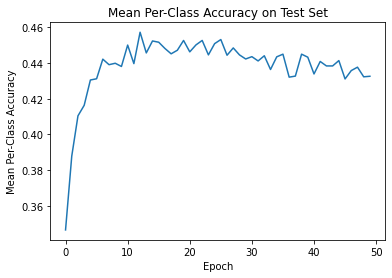

In [ ]:
from matplotlib import pyplot as plt
x_val = list(range(0, 50))
plt.plot(x_val,mean_class_accuracies[0:50])
plt.xlabel("Epoch")
plt.ylabel("Mean Per-Class Accuracy")
plt.title("Mean Per-Class Accuracy on Test Set")

In [ ]:
torch.save(model, "convnet1")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CifarNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
model.conv1.weight.shape
conv1_weights = model.conv1.weight.clone()
conv1_weights.shape
for filt in conv1_weights:
  min_val = torch.min(filt)
  filt -= min_val
  max_val = torch.max(filt)
  filt /= max_val
print(conv1_weights.shape)


torch.Size([64, 3, 11, 11])


(3, 49, 193)


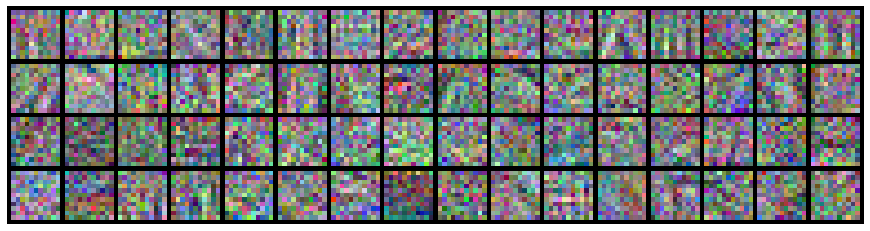

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.figure(figsize=(16,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    
    plt.show()
# show images
imshow(torchvision.utils.make_grid(conv1_weights.cpu().detach(), nrow=16, padding=1))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CifarNetBN(nn.Module):
    def __init__(self):
        super(CifarNetBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, (11,11))
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d((2,2), 2)
        self.conv2 = nn.Conv2d(64, 128, (3,3))
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, (3,3))
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(128)
        self.avgpool = nn.AvgPool2d((2,2), 2)
        self.fc1 =  nn.Linear(128 * 3 * 3, 10)
        torch.nn.init.kaiming_normal_(self.fc1.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.avgpool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [ ]:
from torch.utils import data
from torch import nn, optim
import os
import torch
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

model = CifarNetBN()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.004)
model.to(device)

# Parameters
max_epochs = 50
training_losses_bn = []
mean_class_accuracies = []
confusion_matrix = torch.zeros(10, 10)

# Loop over epochs
for epoch in range(max_epochs):
    running_loss_train = 0.0
    running_loss_test = 0.0
    num_items_train = 0
    num_items_test = 0
    confusion_matrix = torch.zeros(10, 10)
    # Training
    for local_batch, local_labels in trainloader:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        # Model computations
        optimizer.zero_grad()        
        output = model(local_batch)
        loss = criterion(output, local_labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
        num_items_train += local_batch.shape[0]
    print('Training loss: %.10f' %
              (running_loss_train / num_items_train))
    training_losses_bn.append(running_loss_train / num_items_train)

    # Validation
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in testloader:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            output = model(local_batch)
            preds = torch.argmax(output, dim=1)

            loss = criterion(output, local_labels)
            running_loss_test += loss.item()
            num_items_test += local_batch.shape[0]

            for t, p in zip(local_labels.view(-1), preds.view(-1)):
              confusion_matrix[t.long(), p.long()] += 1

    print('Testing loss: %.10f' % (running_loss_test / num_items_test))
    # Calculate Mean Per Class Accuracies
    class_accs = []
    confusion_matrix = np.array(confusion_matrix)
    for actual_class_ind in range(0,len(confusion_matrix)):
      class_acc = confusion_matrix[actual_class_ind][actual_class_ind] / confusion_matrix[actual_class_ind].sum()
      class_accs.append(class_acc)
    class_accs = np.array(class_accs)
    acc_percent = class_accs.sum()/len(class_accs)
    print(acc_percent)
    mean_class_accuracies.append(acc_percent)

cuda:0
Training loss: 0.0128737743
Testing loss: 0.0112336006
0.499399995803833
Training loss: 0.0097120835
Testing loss: 0.0090461856
0.597599983215332
Training loss: 0.0081075192
Testing loss: 0.0079981607
0.6512000083923339
Training loss: 0.0071466243
Testing loss: 0.0076176886
0.6694000244140625
Training loss: 0.0064787120
Testing loss: 0.0072422573
0.6864999771118164
Training loss: 0.0058110174
Testing loss: 0.0071507739
0.6871999740600586
Training loss: 0.0053057922
Testing loss: 0.0071381228
0.6944000244140625
Training loss: 0.0047420411
Testing loss: 0.0075486765
0.6861000061035156
Training loss: 0.0042994637
Testing loss: 0.0076275269
0.6903000354766846
Training loss: 0.0038419061
Testing loss: 0.0081010544
0.6777999877929688
Training loss: 0.0033808817
Testing loss: 0.0080401987
0.6996999740600586
Training loss: 0.0030184161
Testing loss: 0.0088225207
0.6826000213623047
Training loss: 0.0026167255
Testing loss: 0.0091819649
0.6901000022888184
Training loss: 0.0023702884
Testi

Text(0.5, 1.0, 'Training Loss as a Function of Epoch')

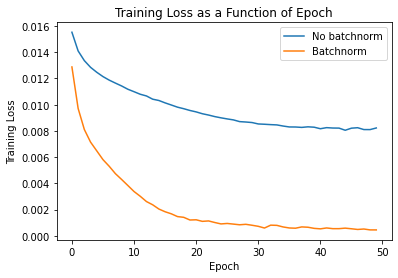

In [ ]:
from matplotlib import pyplot as plt
x_val = list(range(0, 50))
plt.plot(x_val,training_losses[0:50], label="No batchnorm")
plt.plot(x_val,training_losses_bn[0:50], label="Batchnorm")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss as a Function of Epoch")

torch.Size([64, 3, 11, 11])
(3, 49, 193)


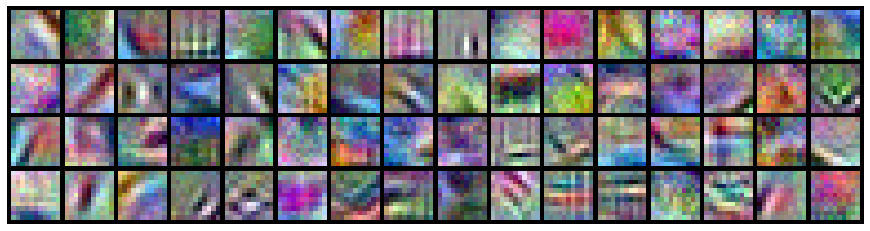

In [ ]:
model.conv1.weight.shape
conv1_weights = model.conv1.weight.clone()
conv1_weights.shape
for filt in conv1_weights:
  min_val = torch.min(filt)
  filt -= min_val
  max_val = torch.max(filt)
  filt /= max_val
print(conv1_weights.shape)

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.figure(figsize=(16,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    
    plt.show()

# show images
imshow(torchvision.utils.make_grid(conv1_weights.cpu().detach(), nrow=16, padding=1))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CifarNetGN(nn.Module):
    def __init__(self):
        super(CifarNetGN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, (3,3))
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d((2,2), 2)
        self.conv2 = nn.Conv2d(64, 128, (3,3))
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, (3,3))
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, (3,3))
        torch.nn.init.kaiming_normal_(self.conv4.weight)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, (3,3))
        torch.nn.init.kaiming_normal_(self.conv5.weight)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, (3,3))
        torch.nn.init.kaiming_normal_(self.conv6.weight)
        self.bn6 = nn.BatchNorm2d(128)
        self.avgpool = nn.AvgPool2d((2,2), 2)
        self.fc1 =  nn.Linear(128 * 4, 120)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 =  nn.Linear(120, 10)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = F.relu(self.conv6(x))
        x = self.bn6(x)
        x = self.avgpool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


import torch
from torch.utils import data
from torch import nn, optim

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

model = CifarNetGN()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.004)
model.to(device)

# Parameters
max_epochs = 50
training_losses_gn = []
mean_class_accuracies = []
confusion_matrix = torch.zeros(10, 10)

# Loop over epochs
for epoch in range(max_epochs):
    running_loss_train = 0.0
    running_loss_test = 0.0
    num_items_train = 0
    num_items_test = 0
    confusion_matrix = torch.zeros(10, 10)
    # Training
    for local_batch, local_labels in trainloader:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        # Model computations
        optimizer.zero_grad()        
        output = model(local_batch)
        loss = criterion(output, local_labels)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()
        num_items_train += local_batch.shape[0]
    print('Training loss: %.10f' %
              (running_loss_train / num_items_train))
    training_losses_bn.append(running_loss_train / num_items_train)

    # Validation
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in testloader:
            # Transfer to GPU
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            output = model(local_batch)
            preds = torch.argmax(output, dim=1)

            loss = criterion(output, local_labels)
            running_loss_test += loss.item()
            num_items_test += local_batch.shape[0]

            for t, p in zip(local_labels.view(-1), preds.view(-1)):
              confusion_matrix[t.long(), p.long()] += 1

    print('Testing loss: %.10f' % (running_loss_test / num_items_test))
    # Calculate Mean Per Class Accuracies
    class_accs = []
    confusion_matrix = np.array(confusion_matrix)
    for actual_class_ind in range(0,len(confusion_matrix)):
      class_acc = confusion_matrix[actual_class_ind][actual_class_ind] / confusion_matrix[actual_class_ind].sum()
      class_accs.append(class_acc)
    class_accs = np.array(class_accs)
    acc_percent = class_accs.sum()/len(class_accs)
    print(acc_percent)
    mean_class_accuracies.append(acc_percent)

cuda:0
Training loss: 0.0131199360
Testing loss: 0.0098809669
0.5535999774932862
Training loss: 0.0086575740
Testing loss: 0.0090803609
0.5942999839782714
Training loss: 0.0073867142
Testing loss: 0.0069672506
0.6939000129699707
Training loss: 0.0061017501
Testing loss: 0.0061954731
0.7290999889373779
Training loss: 0.0051891938
Testing loss: 0.0056472271
0.7581999778747559
Training loss: 0.0054097144
Testing loss: 0.0059196649
0.7427000045776367
Training loss: 0.0044874904
Testing loss: 0.0053879158
0.7709000587463379
Training loss: 0.0037984171
Testing loss: 0.0052706601
0.7785999774932861
Training loss: 0.0032934067
Testing loss: 0.0054345429
0.7783999919891358
Training loss: 0.0029235959
Testing loss: 0.0054425806
0.7819000244140625
Training loss: 0.0025638617
Testing loss: 0.0055048244
0.7875000476837158
Training loss: 0.0022412101
Testing loss: 0.0058440455
0.7779999732971191
Training loss: 0.0019541900
Testing loss: 0.0060925763
0.7855000019073486
Training loss: 0.0017807813
Tes

## Adverserial Attack

In [ ]:
!pip install torch==1.4.0
#restart env

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.4/753.4 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.4.0 which is incompatible.
torchtext 0.14.1 requires torch==1.13.1, but you have torch 1.4.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.4.0 which is incompatible.
fastai 2.7.10 requires torch<1.14,>=1.7, but you have torch 1.4.0 which is incompatible.


In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet152', pretrained=True)
model = model.eval()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
def load_initial_image_from_path(path):
  from PIL import Image
  from torchvision import transforms
  input_image = Image.open(path)
  return load_initial_image(input_image)

In [ ]:
def load_initial_image(input_image):
  from PIL import Image
  from torchvision import transforms
  preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')
  return input_batch

In [ ]:
# This only normalizes the pixel values without centering / resizing 
def load_initial_image_mod(input_image):
  from PIL import Image
  from torchvision import transforms
  preprocess_mod = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input_tensor = preprocess_mod(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')
  return input_batch

In [ ]:
def adverserial_attack(num_epochs, unsqueezed_img, fake_class, 
                       model, lbda, e):
  from torch import nn
  import numpy as np
  # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  means = np.array([0.485, 0.456, 0.406])
  stds = np.array([0.229, 0.224, 0.225])
  max_vals = torch.tensor([(1-means)/stds]).float().to('cuda')
  min_vals = torch.tensor([-means/stds]).float().to('cuda')
  min_red = min_vals[0][0].item()
  min_green = min_vals[0][1].item()
  min_blue = min_vals[0][2].item()
  max_red = max_vals[0][0].item()
  max_green = max_vals[0][1].item()
  max_blue = max_vals[0][2].item()

  unsqueezed_img.requires_grad = True
  for epoch in range(num_epochs):
    output = model(unsqueezed_img)
    criterion = nn.CrossEntropyLoss()
    loss_fake = criterion(output, fake_class)
    model.zero_grad()
    loss_fake.backward()
    gradient = unsqueezed_img.grad.data
    squeezed_gradient = gradient.squeeze()
    diff_lam = torch.mul(squeezed_gradient, lbda)
    input_squeezed = unsqueezed_img.squeeze()
    new_img = torch.sub(input_squeezed, diff_lam) 
    clipped = torch.max(torch.min(new_img, input_squeezed + e), input_squeezed - e)
    clipped_r = clipped[0]
    clipped_g = clipped[1]
    clipped_b = clipped[2]
    clamped_r = torch.clamp(clipped_r, min_red, max_red)
    clamped_g = torch.clamp(clipped_g, min_green, max_green)
    clamped_b = torch.clamp(clipped_b, min_blue, max_blue)
    clamped_new = torch.stack([clamped_r, clamped_g, clamped_b])
    unsqueezed_img = clamped_new.unsqueeze(0).detach() 
    unsqueezed_img.requires_grad = True
  return unsqueezed_img

In [ ]:
def generate_adverserial_image(model, img, fake_class, e, lbda, epochs):
  import numpy as np
  fake_class = torch.from_numpy(np.array([fake_class])).to("cuda")
  new_img = adverserial_attack(epochs ,img, fake_class, model, lbda, e)
  return new_img

In [ ]:
from torchvision import transforms
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

In [ ]:
def predict_class_and_prob(normalized_img, model):
  import numpy as np
  with torch.no_grad():
    output = model(normalized_img)
  probs = torch.nn.functional.softmax(output[0], dim=0)
  cpu_probs = probs.cpu()
  highest_class_idx = np.argpartition(cpu_probs, -1)[-1:]
  prob = cpu_probs[highest_class_idx]
  return highest_class_idx, prob

In [ ]:
def run_adverserial(img_paths, model, fake_classes, imagenet_cls_map):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(10, 15))
  adv_images = []
  for idx, img_path in enumerate(img_paths):
    # Load Images
    unsq_img = load_initial_image_from_path(img_path)
    # Get most likely class and probability
    cls_pred, prob = predict_class_and_prob(unsq_img, model)
    # Generate adverserial image
    adv_image = generate_adverserial_image(model, unsq_img, fake_classes[idx], .01, .1, 50)
    # Adverserial most likely class and probability
    ad_cls_pred, ad_prob = predict_class_and_prob(adv_image, model)
    real_image_norm = inv_normalize(unsq_img.cpu().detach().squeeze())
    fake_image_norm = inv_normalize(adv_image.cpu().detach().squeeze())
    adv_images.append(adv_image)
    # Get noise and amplify by 100
    noise = torch.sub(adv_image.cpu().detach().squeeze().permute(1, 2, 0),unsq_img.cpu().detach().squeeze().permute(1, 2, 0))
    # Display and format
    plt.subplot(4, 3, idx*3 + 1)
    plt.imshow(real_image_norm.permute(1, 2, 0))
    plt.title("Most Likely Class: " + str(cls_pred[0].item()) + ", " + \
              imagenet_cls_map[cls_pred[0].item()] + \
              "\n Probability: " + str(round(prob[0].item(),6)))
    plt.axis("off")
    plt.subplot(4, 3, idx*3 + 2)
    plt.imshow(noise * 100)
    plt.title("Noise x 100")
    plt.axis("off")
    plt.subplot(4, 3, idx*3 + 3)
    plt.imshow(fake_image_norm.permute(1, 2, 0))
    plt.title("Most Likely Class: " + str(ad_cls_pred[0].item()) + ", " + \
                            imagenet_cls_map[ad_cls_pred[0].item()] + \
              "\n Probability: " + str(round(ad_prob[0].item(),5)))
    plt.axis("off")
  plt.show()
  return adv_images

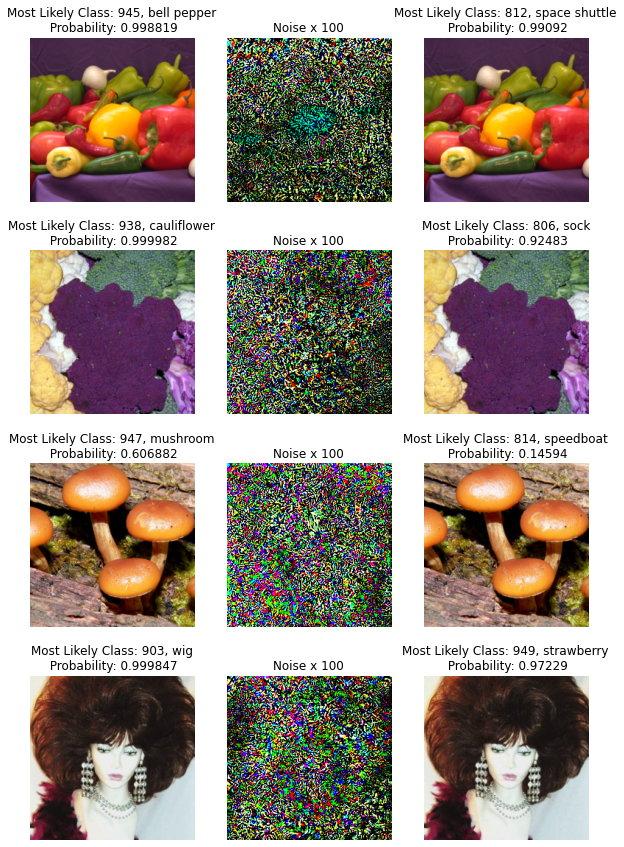

In [ ]:
import numpy as np
img_paths = ["/content/drive/My Drive/peppers.jpg",
             "/content/drive/My Drive/cauliflower.jpg",
             "/content/drive/My Drive/mushroom.jpg", "/content/drive/My Drive/wig.jpg"]
fake_classes = [812, 806, 814, 949]
imgnet_class_list = np.loadtxt("/content/drive/My Drive/imagenet_classes.txt",dtype='str', delimiter="\n")
adv_images = run_adverserial(img_paths,model, fake_classes, imgnet_class_list)

In [ ]:
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
img_titles = ['Peppers', "Cauliflower", "Mushroom", "Wig"]
for i in range(len(adv_images)):
  fig = plt.figure(figsize=(15, 10))
  fig.suptitle(img_titles[i], fontsize=16)
  original_adv = adv_images[i]
  original_pred = predict_class_and_prob(original_adv, model)
  img_denormalized = inv_normalize(original_adv.cpu().detach().squeeze(0))
  pil_img = transforms.ToPILImage(mode='RGB')(img_denormalized)
  # Mirror
  flipped_v = ImageOps.flip(pil_img)
  flipped_h = ImageOps.mirror(pil_img)
  # Crop
  cropped = ImageOps.crop(pil_img,24)
  # Rotate
  rotated = pil_img.rotate(30)
  # Greyscale
  greyscale = pil_img.convert('L')
  stacked_greyscale = np.stack((greyscale,)*3, axis=-1)
  greyscale_rep = transforms.ToPILImage(mode='RGB')(stacked_greyscale)
  
  add_to_plot(pil_img,1,"Original Adv.: \n" + convert_and_predict(pil_img))
  add_to_plot(flipped_v,2,"Flipped V: \n"+ convert_and_predict(flipped_v))
  add_to_plot(flipped_h,3,"Flipped H: \n"+ convert_and_predict(flipped_h))
  add_to_plot(cropped,4,"Cropped: \n"+ convert_and_predict(cropped))
  add_to_plot(rotated,5,"Rotated: \n"+ convert_and_predict(rotated))
  add_to_plot(greyscale_rep,6,"Greyscale: \n"+ convert_and_predict(greyscale_rep))


In [ ]:
imgnet_class_list = np.loadtxt("imagenet_classes.txt",dtype='str', delimiter="\n")
def add_to_plot(img, idx, title):
  plt.subplot(2, 3, idx)
  plt.imshow(img)
  plt.axis("off")
  plt.title(title)

def convert_and_predict(img):
  back_to_pytorch = load_initial_image_mod(img)
  cls_pred, prob = predict_class_and_prob(back_to_pytorch, model)
  title_str = ("Most Likely Class: " + str(cls_pred[0].item()) + ", " + \
            imgnet_class_list[cls_pred[0].item()] + \
            "\n Probability: " + str(round(prob[0].item(),5)))
  return title_str